In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pickle


lb_make = LabelEncoder()

In [2]:
train_df = pd.read_csv("/content/drive/MyDrive/ClickBait/data/webis_train.csv")
train_df = train_df.dropna(subset=['postText', 'truthClass'])

train_df["label"] = lb_make.fit_transform(train_df["truthClass"])


In [3]:
train_df.head(3)

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode,label
0,0,[],UK’s response to modern slavery leaving victim...,858462320779026432,['modern-slavery-rex.jpg'],['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000,1
1,1,[],this is good,858421020331560960,"['In this July 1, 2010 file photo, Dr. Charmai...",['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000,0
2,2,[],"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,"[""President Trump will not attend this year's ...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333,1


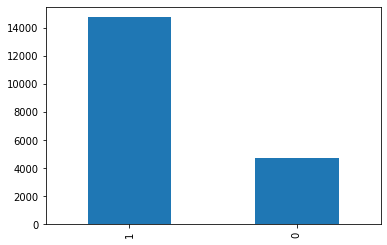

In [4]:
train_df["label"].value_counts().plot(kind="bar")

In [5]:
test_df = pd.read_csv("/content/drive/MyDrive/ClickBait/data/webis_test.csv")
test_df = test_df.dropna(subset=['postText', 'truthClass'])

test_df["label"] = lb_make.fit_transform(test_df["truthClass"])

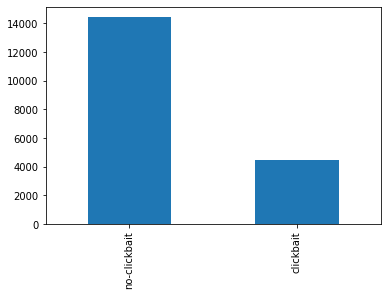

In [6]:
test_df["truthClass"].value_counts().plot(kind="bar")

In [7]:
# Baseline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()


In [8]:
steps = (
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC())
)

pipeline = Pipeline(steps)



In [9]:
train, test = train_test_split(
    test_df,                    # Nuestro dataset
    train_size=0.7,             # Tamaño del subconjunto para entrenamiento
    stratify=test_df["label"],  # Los labelsl que usaremos para la estratificación
    random_state=42             # Semilla para hacer repetible el entrenamiento
)

In [10]:
# Preparamos los parámetros para el gridsearch
gs_params = {
    'vectorizer__stop_words': ['english', None],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [11]:
# Entrenamiento con gridsearch
gs = GridSearchCV(pipeline, gs_params, n_jobs=-1)
gs.fit(train["postText"], train["label"])


GridSearchCV(estimator=Pipeline(steps=(('vectorizer', TfidfVectorizer()),
                                       ('classifier', LinearSVC()))),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'vectorizer__stop_words': ['english', None]})

In [12]:
# Imprimimos los metadatos del mejor modelo
print(gs.best_params_)
print(gs.best_score_)

{'classifier__C': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}
0.8277058791974496


In [13]:
pipeline = gs.best_estimator_
predicted_labels = pipeline.predict(test["postText"])

# Imprimimos los resultados con el conjunto de prueba del split que
# generamos en pasos anteriores
print(classification_report(predicted_labels, test["label"]))

              precision    recall  f1-score   support

           0       0.47      0.69      0.56       915
           1       0.93      0.85      0.89      4759

    accuracy                           0.82      5674
   macro avg       0.70      0.77      0.72      5674
weighted avg       0.86      0.82      0.84      5674



In [14]:
with open("tfidf_lsvc.model", 'wb') as f:
  pickle.dump(pipeline, f)

In [15]:
# Usamos el conjunto de validación definidio al principio del notebook
# Estos ejemplos no han sido usados en ningúun momento durante el entrenamiento
predicted_labels = pipeline.predict(test_df["postText"])

print(classification_report(predicted_labels, test_df["label"]))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4017
           1       0.98      0.95      0.96     14896

    accuracy                           0.95     18913
   macro avg       0.91      0.94      0.92     18913
weighted avg       0.95      0.95      0.95     18913



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


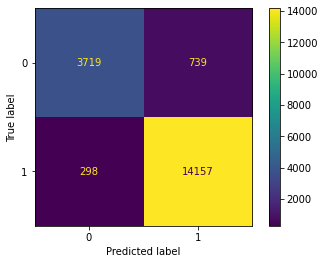

In [16]:
plot_confusion_matrix(pipeline, test_df["postText"], test_df["label"])  
plt.show()

In [17]:
# Implementación de un modelo de clasificación con BERT
!pip install tensorflow_text
!pip install -q tf-models-official


import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

     |████████████████████████████████| 4.9 MB 8.1 MB/s 
     |████████████████████████████████| 462 kB 73.5 MB/s 
     |████████████████████████████████| 2.2 MB 8.7 MB/s 
     |████████████████████████████████| 99 kB 11.5 MB/s 
     |████████████████████████████████| 1.2 MB 34.9 MB/s 
     |████████████████████████████████| 237 kB 58.0 MB/s 
     |████████████████████████████████| 90 kB 11.0 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 56.5 MB/s 
     |████████████████████████████████| 636 kB 66.1 MB/s 
     |████████████████████████████████| 352 kB 81.2 MB/s 
     |████████████████████████████████| 47.8 MB 1.8 MB/s 


In [18]:
# Cargar módulos de tensorflow hub para preprocesamiento con bert
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [19]:
# Entrada de datos y preprocesamiento
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [38]:
# Configuración de la red neuronal, 1 unidad densa con activación sigmoide en
# la capa de salida
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [21]:
# Métricas para monitoreo durante el entrenamiento
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# Compilación del modelo usando el optimizador Adam y una pérdida de entropía 
# binaria
model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [22]:
# Entrenamiento del modelo, según disponibilidad del TPU/GPU de 8 minutos por
# epoch hasta 2 horas por epoch

model.fit(x=[train_df["postText"], train_df["label"], epochs=10)


Epoch 1/10
609/609 [==============================] - 218s 322ms/step - loss: 0.4577 - accuracy: 0.7915 - precision: 0.8040 - recall: 0.9586
Epoch 2/10
609/609 [==============================] - 197s 324ms/step - loss: 0.4180 - accuracy: 0.8092 - precision: 0.8347 - recall: 0.9330
Epoch 3/10
609/609 [==============================] - 197s 324ms/step - loss: 0.4058 - accuracy: 0.8183 - precision: 0.8449 - recall: 0.9312
Epoch 4/10
609/609 [==============================] - 197s 323ms/step - loss: 0.4005 - accuracy: 0.8197 - precision: 0.8488 - recall: 0.9273
Epoch 5/10
609/609 [==============================] - 197s 323ms/step - loss: 0.3977 - accuracy: 0.8199 - precision: 0.8508 - recall: 0.9246
Epoch 6/10
609/609 [==============================] - 197s 323ms/step - loss: 0.3952 - accuracy: 0.8221 - precision: 0.8534 - recall: 0.9240
Epoch 7/10
609/609 [==============================] - 197s 323ms/step - loss: 0.3932 - accuracy: 0.8242 - precision: 0.8553 - recall: 0.9244
Epoch 8/10
60

In [23]:
# Almacenamiento del modelo para utulizarlo posteriormente
model.save_weights('/content/drive/MyDrive/ClickBait/data/bert_weights_10e.h5')


In [24]:
# Predicciones con el conjunto de evaluación
y_predicted = model.predict(test_df["postText"])
y_predicted = y_predicted.flatten()

In [25]:
# Aplicación del umbral de predicción
y_predicted_bin = np.where(y_predicted > 0.5, 1, 0)

In [26]:
print(classification_report(y_predicted_bin, test_df["label"]))

              precision    recall  f1-score   support

           0       0.41      0.79      0.54      2330
           1       0.97      0.84      0.90     16583

    accuracy                           0.84     18913
   macro avg       0.69      0.81      0.72     18913
weighted avg       0.90      0.84      0.86     18913



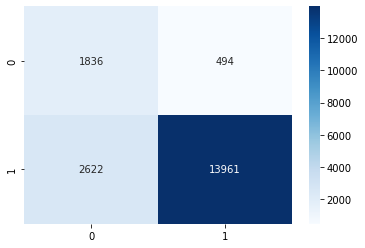

In [37]:
# Matriz de confusión
cf_matrix = confusion_matrix(y_predicted_bin, test_df["label"])
sn.heatmap(cf_matrix, fmt='', annot=True, cmap='Blues')
